In [223]:
import warnings
import cv2
import numpy as np
from skimage.morphology import disk, erosion
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

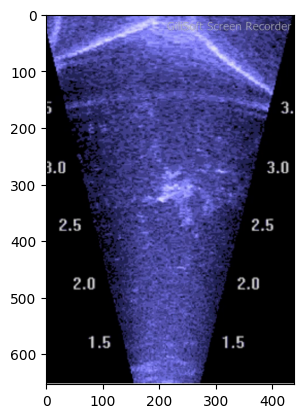

In [2]:
image = cv2.imread( "sample.png")	# reading input image

image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB)	# converting color channels from BGR to RGB

plt.imshow( image)

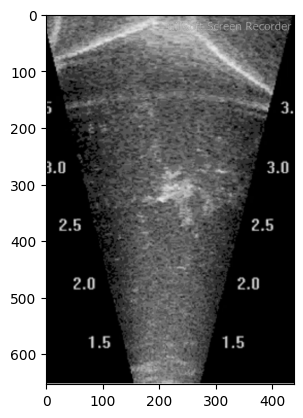

In [3]:
gray_image = cv2.cvtColor( image, cv2.COLOR_BGR2GRAY)	# converting image to Gray

plt.imshow( gray_image, cmap="gray")

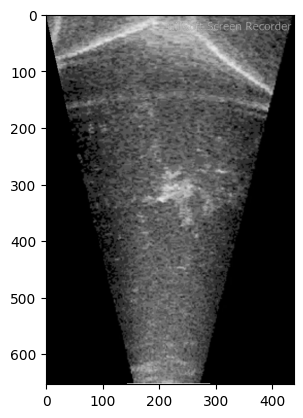

In [4]:
# removing unwanted margins

height, width = gray_image.shape

mask = np.zeros_like( gray_image)

# creating a polygon shape for interested region/area
polygon = np.array( [
	[ width * 0.33, height],	# Bottom-left
	[ width * 0.66, height],	# Botton-Right
	[ width, 0],				# Top-Right
	[ 0, 0],					# Top-Left
], np.int32)

mask = cv2.fillPoly( mask, [ polygon], 255)

masked_image = cv2.bitwise_and( gray_image, mask)

plt.imshow( masked_image, cmap="gray")

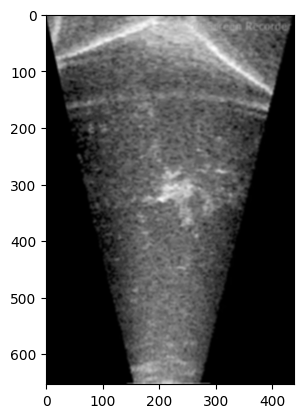

In [5]:
# Bluring Image for denoising
blurred_image = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

plt.imshow( blurred_image, cmap="gray")

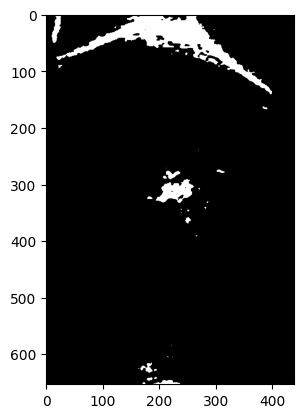

In [216]:
# Thresholding the brightness

c = 0.6

_, binary_image = cv2.threshold( blurred_image, c * 255, 255, cv2.THRESH_BINARY)

plt.imshow( binary_image, cmap="gray")

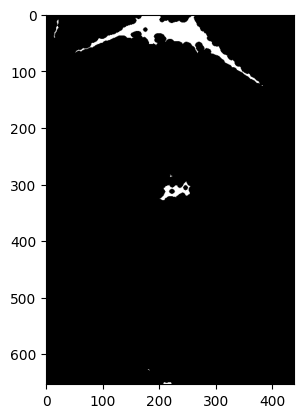

In [226]:
# Eroding the binary image to remove small noise

footprint = disk( 4)

eroded_frame = erosion( binary_image, footprint)

plt.imshow( eroded_frame, cmap="gray")

In [8]:
# selecting bright pixels
bright_pixels = np.column_stack( np.where( eroded_frame > 0))

In [155]:
def co_dist( centeroids):
	with warnings.catch_warnings():
		warnings.filterwarnings( "ignore")
		c = np.array( [ [ np.linalg.norm( centeroids[ i] - centeroids[ j]) for j in range( len( centeroids))] for i in range( len( centeroids))])

		for i in range( len( c)):
			c[ i][ i] = float( "inf")

		c[ np.isnan( c)] = float( "inf")

		return c

In [156]:
kmeans = KMeans( n_clusters=70, n_init="auto").fit( bright_pixels)

labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

c = co_dist( kmeans_cluster_centers)

while ( c < 50).any():
	a, b = np.unravel_index( c.argmin(), c.shape)

	a_n = ( labels == a).sum()
	b_n = ( labels == b).sum()

	kmeans_cluster_centers[ a] = ( ( a_n * kmeans_cluster_centers[ a]) + ( b_n * kmeans_cluster_centers[ b])) / ( a_n + b_n)

	kmeans_cluster_centers[ b] = float( "inf")
	
	labels[ labels == b] = a

	c = co_dist( kmeans_cluster_centers)

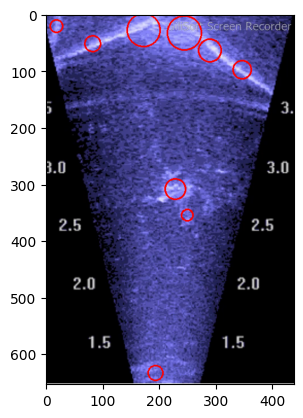

In [194]:
cluster_idx = np.where( np.isfinite( kmeans_cluster_centers).all( axis=1))[ 0]
cluster_centers = kmeans_cluster_centers[ cluster_idx].astype( int)

output_image = image.copy()

for i, c in enumerate( cluster_centers):
	cluster_weight = ( labels == cluster_idx[ i]).sum()
	cv2.circle( output_image, ( c[ 1], c[ 0]), int( 10 + ( cluster_weight / 200)), ( 255, 0, 0), 2)

plt.imshow( output_image)

In [158]:
np.array( cluster_centers)

array([[ 28, 172],
       [309, 228],
       [ 98, 346],
       [634, 193],
       [ 52,  82],
       [ 64, 289],
       [ 33, 244],
       [ 21,  18],
       [355, 249]])

In [159]:
def read_every_nth_frame( video_capture, n):
	frame_count = 0
	frames = []
	while video_capture.isOpened():
		ret, frame = video_capture.read()

		if not ret:
			break

		if frame_count % n == 0:
			frames.append( cv2.cvtColor( frame, cv2.COLOR_BGR2RGB))

		frame_count += 1

	return np.array( frames)

In [160]:
cap = cv2.VideoCapture( "image/MyRecord_20241116133821.mp4")

if cap.isOpened() == False:
	print( "Error Opening Video stream")

frames = read_every_nth_frame( cap, 1)

In [227]:
from tqdm.auto import tqdm

def generate( frames):
	output = []

	for f in tqdm( frames):
		output_image = f.copy()

		gray_frame = cv2.cvtColor( f, cv2.COLOR_BGR2GRAY)

		height, width = gray_frame.shape

		mask = np.zeros_like( gray_frame)

		polygon = np.array( [
			[ width * 0.33, height],	# Bottom-left
			[ width * 0.66, height],	# Botton-Right
			[ width, 0],				# Top-Right
			[ 0, 0],					# Top-Left
		], np.int32)

		mask = cv2.fillPoly( mask, [ polygon], 255)

		masked_image = cv2.bitwise_and( gray_frame, mask)

		blurred_frame = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

		c = 0.6

		_, binary_frame = cv2.threshold( blurred_frame, c * 255, 255, cv2.THRESH_BINARY)

		footprint = disk( 4)

		eroded_frame = erosion( binary_frame, footprint)

		bright_pixels = np.column_stack( np.where( eroded_frame > 0))

		k = 15
		min_dist = 75
		
		if len( bright_pixels) < 1:
			output.append( output_image)
			continue

		kmeans = KMeans( n_clusters=50, n_init="auto").fit( bright_pixels)

		labels = kmeans.labels_
		kmeans_cluster_centers = kmeans.cluster_centers_

		c = co_dist( kmeans_cluster_centers)

		while ( c < min_dist).any():
			a, b = np.unravel_index( c.argmin(), c.shape)

			a_n = ( labels == a).sum()
			b_n = ( labels == b).sum()

			kmeans_cluster_centers[ a] = ( ( a_n * kmeans_cluster_centers[ a]) + ( b_n * kmeans_cluster_centers[ b])) / ( a_n + b_n)

			kmeans_cluster_centers[ b] = float( "inf")
			
			labels[ labels == b] = a

			c = co_dist( kmeans_cluster_centers)

		cluster_idx = np.where( np.isfinite( kmeans_cluster_centers).all( axis=1))[ 0]
		cluster_centers = kmeans_cluster_centers[ cluster_idx].astype( int)

		for i, c in enumerate( cluster_centers):
			cluster_weight = ( labels == cluster_idx[ i]).sum()
			cv2.circle( output_image, ( c[ 1], c[ 0]), int( 10 + ( cluster_weight / 200)), ( 255, 0, 0), 2)

		output.append( output_image)

	return output

In [228]:
o = generate( frames)

  0%|          | 0/597 [00:00<?, ?it/s]

In [229]:
height, width, _ = o[ 0].shape

fourcc = cv2.VideoWriter_fourcc( *"MP4V")
video = cv2.VideoWriter( "videogggg.mp4", fourcc, 24, ( width, height))

for f in o:
	video.write( cv2.cvtColor( f, cv2.COLOR_RGB2BGR))

video.release()